###  Оценка влияния рекламы чая «Ахмад» в передаче «Что? Где? Когда?» на его продажи.

Проводится оценка не только одного сорта чай "Ахмад", но также двух других сортов: "Май" и "Липтон"

In [1]:
# Импортируем необходимые библиотека
import pandas as pd
import numpy as np

import matplotlib
import seaborn as sns
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

import requests
from pprint import pprint
from bs4 import BeautifulSoup  
import re
import json

import datetime
from datetime import datetime
import locale

# 1. Парсинг данных о датах проведения передачи «Что? Где? Когда?»

информацию нашел на официальном сайте передачи http://chgk.tvigra.ru/letopis/

In [2]:
# с основного сайтa получаю информацию о датах игр
base_url = 'http://chgk.tvigra.ru/letopis/'
user_agent = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36"
headers = {'User-Agent': user_agent}


In [3]:
response = requests.get(base_url, headers = headers)
if response.status_code == 200:  # проверка отклика с сайта
            page = BeautifulSoup(response.content.decode('utf-8'),
                                 'html.parser')

In [4]:
# выбираем годы игр с сайта
rows = page.find_all('span')
years = ['?1976', '?1977', '?1978'] #  с парсингом этих годов возникли проблемы
for span in rows[2:]:
    years.append('?' + str(span.attrs['id'])) 

In [5]:
%%time
date_list = [] # перечень дат в которые проходили игры

for year in years:
    # для 4 годов данные на сайте завернуты не так как для всех остальных
#     пойэтому их выделил отедльно
    if year == '?1976':
        date_list.append('24 апреля ' + year[1:])
    if year == '?1977':
        date_list.append('24 декабря ' + year[1:]) 
    if year == '?1978':
        date_list.append('14 января ' + year[1:])
        date_list.append('2 декабря ' + year[1:]) 
    if year == '?1987':
        date_list.append('13 ноября ' + year[1:]) 
        date_list.append('14 ноября ' + year[1:]) 
        date_list.append('15 ноября ' + year[1:]) 
    else:
#         для всех остальных годов данный парсирись по следующему коду
        html_year = requests.get(base_url + year).text
        soup_year = BeautifulSoup(html_year, 'html.parser')
        dates = soup_year.find_all('li')
        for date in dates:
            try:
                date_list.append(date.find('a').text + ' ' + year[1:]) 
            except:
                continue

#  в процессе проверки найдены кривые занчения для 1999 года.
# январские серии игр 2000 попали в 1999 год на сайте
#  небольшая коррекция перечня дат игры понадобилась
for elem in date_list:
    if 'года 1999' in elem:
        date_list[date_list.index(elem)]=elem[:-10]    
        
date_list

Wall time: 11.4 s


['24 апреля 1976',
 '24 декабря 1977',
 '14 января 1978',
 '2 декабря 1978',
 '24 января 1979',
 '19 марта 1979',
 '9 апреля 1979',
 '14 июня 1979',
 '9 августа 1979',
 '17 сентября 1979',
 '25 октября 1979',
 '14 ноября 1979',
 '30 января 1980',
 '27 февраля 1980',
 '9 апреля 1980',
 '23 апреля 1980',
 '5 июня 1980',
 '8 июля 1980',
 '20 августа 1980',
 '3 октября 1980',
 '13 ноября 1980',
 '27 ноября 1980',
 '25 декабря 1980',
 '24 марта 1981',
 '20 мая 1981',
 '24 июня 1981',
 '15 июля 1981',
 '2 сентября 1981',
 '9 февраля 1982',
 '11 марта 1982',
 '20 апреля 1982',
 '31 мая 1982',
 '1 июля 1982',
 '23 сентября 1982',
 '1 декабря 1982',
 '29 декабря 1982',
 '28 июня 1983',
 '11 августа 1983',
 '13 сентября 1983',
 '18 октября 1983',
 '6 декабря 1983',
 '29 декабря 1983',
 '24 апреля 1984',
 '29 мая 1984',
 '31 июля 1984',
 '30 октября 1984',
 '30 ноября 1984',
 '29 декабря 1984',
 '28 сентября 1985',
 '26 октября 1985',
 '30 ноября 1985',
 '28 декабря 1985',
 '11 апреля 1986',
 '16

 # 2. Построение boxplot для поиска аномалии роста продаж после передачи.

In [6]:
# Рассмотрим датасет с информацией по трем брендам lipton — 29; ahmad — 178; may — 5152.
df_tea = pd.read_csv("data/tea_demand.csv", sep='\t')
df_tea3 = df_tea[(df_tea['brand_id']==5152) | (df_tea['brand_id']==178) | (df_tea['brand_id']==29)]
df_tea3.head()

,brand_id,date,receipts_count
0,5152,2016-07-01,98
1,178,2016-07-01,234
2,29,2016-07-01,622
3,5152,2016-07-02,87
4,178,2016-07-02,185


<AxesSubplot:xlabel='date'>

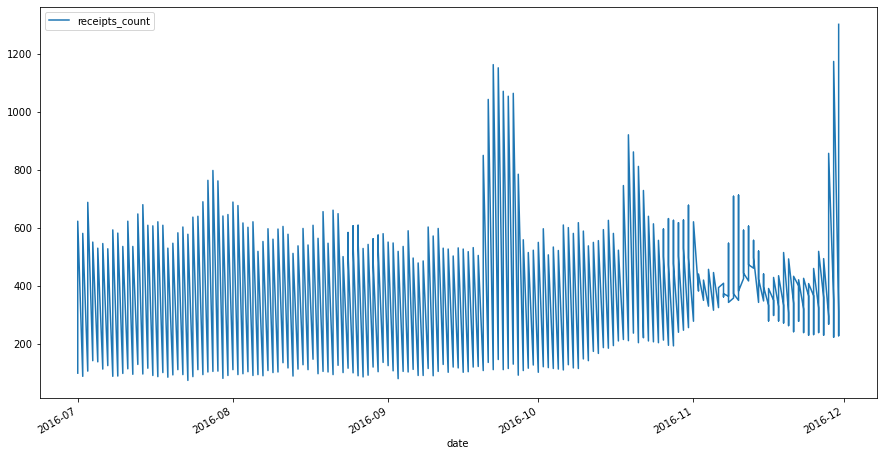

In [7]:
# посмотрим на данные продаж для трех выдов чая

df_tea3['date'] = pd.to_datetime(df_tea3['date'])
df_tea3.plot(x='date', y='receipts_count', figsize=(15,8))


In [8]:
df_tea3['date'].describe()

count                     459
unique                    153
top       2016-09-08 00:00:00
freq                        3
first     2016-07-01 00:00:00
last      2016-11-30 00:00:00
Name: date, dtype: object

Информация только о продажах c июля по декабрь 2016 года. Выделим игры в 2016 году

In [9]:
date_list_16 = []
for elem in date_list:
    if '2016' in elem:
        date_list_16.append(elem)

print(f'Всего в 2016 году было {len(date_list_16)} игр Что? Где? Когда?')          
print(date_list_16)
   

Всего в 2016 году было 20 игр Что? Где? Когда?
['27 марта 2016', '3 апреля 2016', '10 апреля 2016', '17 апреля 2016', '24 апреля 2016', '15 мая 2016', '22 мая 2016', '29 мая 2016', '5 июня 2016', '19 июня 2016', '25 сентября 2016', '2 октября 2016', '9 октября 2016', '16 октября 2016', '23 октября 2016', '20 ноября 2016', '27 ноября 2016', '11 декабря 2016', '18 декабря 2016', '25 декабря 2016']


In [10]:
# Переведем даты игр в формат date для последующей проверки аномалий
date_str = ' '.join([str(elem) for elem in date_list_16])
months = [(' марта ', '-3-'), (' апреля ', '-4-'), (' мая ', '-5-'), (' июня ', '-6-'), (' сентября ', '-9-'), (' октября ', '-10-'), (' ноября ', '-11-'), (' декабря ', '-12-')]
for old, new in months:
    date_str = date_str.replace(old, new)

dates_16 = []
for dt in list(date_str.split(" ")):
    dt_new = datetime.strptime(dt, '%d-%m-%Y')
    dates_16.append(dt_new.strftime('%Y-%m-%d'))

dates_16

['2016-03-27',
 '2016-04-03',
 '2016-04-10',
 '2016-04-17',
 '2016-04-24',
 '2016-05-15',
 '2016-05-22',
 '2016-05-29',
 '2016-06-05',
 '2016-06-19',
 '2016-09-25',
 '2016-10-02',
 '2016-10-09',
 '2016-10-16',
 '2016-10-23',
 '2016-11-20',
 '2016-11-27',
 '2016-12-11',
 '2016-12-18',
 '2016-12-25']

In [11]:
# Так как информация по продажам начинается с июля,
# будем рассматривать игры начиная с июня 2016
date_new = dates_16[9:]
date_new

['2016-06-19',
 '2016-09-25',
 '2016-10-02',
 '2016-10-09',
 '2016-10-16',
 '2016-10-23',
 '2016-11-20',
 '2016-11-27',
 '2016-12-11',
 '2016-12-18',
 '2016-12-25']

<AxesSubplot:xlabel='receipts_count'>

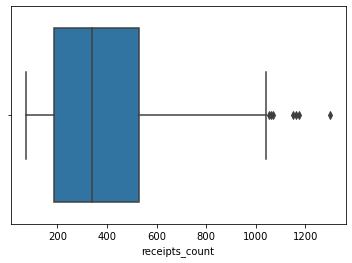

In [12]:
sns.boxplot(x='receipts_count', data=df_tea3)

In [13]:
upper_quartile = np.percentile(df_tea3['receipts_count'], 75)
lower_quartile = np.percentile(df_tea3['receipts_count'], 25)

iqr = upper_quartile - lower_quartile
upper_whisker = df_tea3['receipts_count'][df_tea3['receipts_count'] <= upper_quartile+1.5*iqr].max()


anomaly_n = df_tea3['receipts_count'][df_tea3['receipts_count'] > upper_whisker].value_counts().sum()

print(f'всего аномалий по боксплоту - {anomaly_n}')

всего аномалий по боксплоту - 7


In [14]:
df_anom = df_tea3['date'][df_tea3['receipts_count'] > upper_whisker]
df_anom

251   2016-09-22
254   2016-09-23
257   2016-09-24
260   2016-09-25
263   2016-09-26
455   2016-11-29
458   2016-11-30
Name: date, dtype: datetime64[ns]

In [15]:
def anomaly_date(df):
    '''функция отбора аномалий между датами игр'''
    for i in range(len(date_new)-1):
        start = date_new[i]
        end = date_new[i+1]
        print(f'Аномалии между играми {start} и {end}')
        print(df[df.between(start, end)].dt.strftime('%Y-%m-%d').drop_duplicates().tolist())


In [16]:
anomaly_date(df_anom)

Аномалии между играми 2016-06-19 и 2016-09-25
['2016-09-22', '2016-09-23', '2016-09-24', '2016-09-25']
Аномалии между играми 2016-09-25 и 2016-10-02
['2016-09-25', '2016-09-26']
Аномалии между играми 2016-10-02 и 2016-10-09
[]
Аномалии между играми 2016-10-09 и 2016-10-16
[]
Аномалии между играми 2016-10-16 и 2016-10-23
[]
Аномалии между играми 2016-10-23 и 2016-11-20
[]
Аномалии между играми 2016-11-20 и 2016-11-27
[]
Аномалии между играми 2016-11-27 и 2016-12-11
['2016-11-29', '2016-11-30']
Аномалии между играми 2016-12-11 и 2016-12-18
[]
Аномалии между играми 2016-12-18 и 2016-12-25
[]


#### Выводы:

Как показали расчеты с боксплотом выявлено 7 аномалий, которые приходятся на сентябрь и ноябрь 2016 года. ПРи этом в сентябре была только одна игра - уже практически после всплеска продаж, а в ноябре было всего две игры которые прошли примерно на 10 дней ранее выявленной аномалии в продажах.
По полученным статистическим данным невозможно сказать, что игры как то повлияли на продажи трех видов чая. Таким образом можно сказать что нет аномалии роста продаж после передачи.

# 3. Kластеризации точек продаж (по всем трём вендорам).

### 3.1 K-MEANS

Создадим новый фитчи

In [18]:
# new feature - Season
def get_season(month):
    if (month > 11 or month < 3):
        return 'WINTER'
    if (month == 3 or month <= 5):
        return 'SPRING'
    if (month >= 6 or month <= 9):
        return 'SUMMER'
    else:
        return 'FALL'
    
# функция извлечения дня недели
def weekday_name(weekday):
    days = ['Monday', 'Tuesday', 'Wednesday',
            'Thursday', 'Friday', 'Saturday', 'Sunday']
    return days[weekday]

def getDistanceByPoint(data, model):
    # Расчет расстояний от точек до центров кластеров
    distance = pd.Series(dtype='float64')
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance

# def getTransitionMatrix (df):
#     # Расчет вероятностей перехода к следующему состоянию (глупая предсказывалка)
#     df = np.array(df)
#     model = msm.estimate_markov_model(df, 1)
#     return model.transition_matrix


In [19]:
df_tea3['DayOfTheWeek'] = df_tea3['date'].dt.dayofweek
df_tea3['WeekDay'] = (df_tea3['DayOfTheWeek'] < 5).astype(int)
df_tea3['quarter'] = df_tea3['date'].dt.quarter
df_tea3['month'] = df_tea3['date'].dt.month
df_tea3['dayofyear'] = df_tea3['date'].dt.dayofyear
df_tea3['dayofmonth'] = df_tea3['date'].dt.day
df_tea3['weekofyear'] = df_tea3['date'].dt.weekofyear
df_tea3['weekend'] = np.where(df_tea3['DayOfTheWeek'].isin([5, 6]), 1, 0)

# создаем переменную название дня недели
df_tea3['weekday_name'] = df_tea3['DayOfTheWeek'].apply(lambda x: weekday_name(x))
# создаем переменную сезон
df_tea3['season'] = df_tea3['month'].apply(lambda x: get_season(x))
outliers_fraction = 0.01

In [20]:
df_tea3.sample(5)

,brand_id,date,receipts_count,DayOfTheWeek,WeekDay,quarter,month,dayofyear,dayofmonth,weekofyear,weekend,weekday_name,season
269,29,2016-09-28,558,2,1,3,9,272,28,39,0,Wednesday,SUMMER
211,178,2016-09-09,381,4,1,3,9,253,9,36,0,Friday,SUMMER
148,178,2016-08-19,227,4,1,3,8,232,19,33,0,Friday,SUMMER
225,5152,2016-09-14,119,2,1,3,9,258,14,37,0,Wednesday,SUMMER
65,29,2016-07-22,602,4,1,3,7,204,22,29,0,Friday,SUMMER


In [21]:
data = df_tea3[['receipts_count', 'quarter', 'month', 'DayOfTheWeek',
                'WeekDay', 'dayofyear', 'dayofmonth', 'weekofyear', 'weekend']]

# Нормализуем наши данные
starrd_scaler = preprocessing.StandardScaler().fit(data)
np_scaled = starrd_scaler.transform(data)
data = pd.DataFrame(np_scaled)

# Уменьшим количество компонент
pca = PCA(n_components=2)
data = pca.fit_transform(data)

min_max_scaler = preprocessing.StandardScaler().fit(data)
np_scaled = min_max_scaler.transform(data)
data = pd.DataFrame(np_scaled)

C:\Users\fadee\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


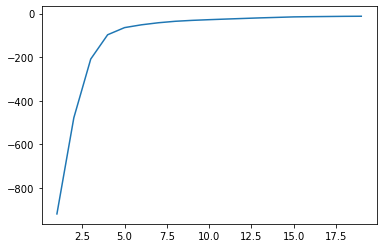

In [22]:
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=j).fit(data) for j in n_cluster]
scores = [km.score(data) for km in kmeans]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [23]:
df_tea3['cluster'] = kmeans[3].predict(data)
df_tea3['principal_feature1'] = data[0]
df_tea3['principal_feature2'] = data[1]
df_tea3['cluster'].value_counts()

0    198
1    129
3     78
2     54
Name: cluster, dtype: int64

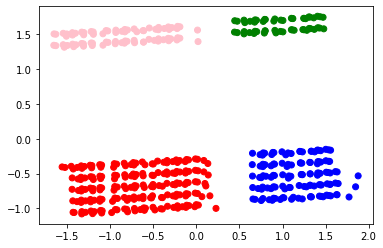

In [24]:
fig, ax = plt.subplots()
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'pink', 4: 'black', 5: 'orange', 6: 'cyan', 7: 'yellow',
          8: 'brown', 9: 'purple', 10: 'white', 11: 'grey', 12: 'lightblue', 13: 'lightgreen', 14: 'darkgrey'}
ax.scatter(df_tea3['principal_feature1'], df_tea3['principal_feature2'],
           c=df_tea3["cluster"].apply(lambda x: colors[x]))
plt.show()

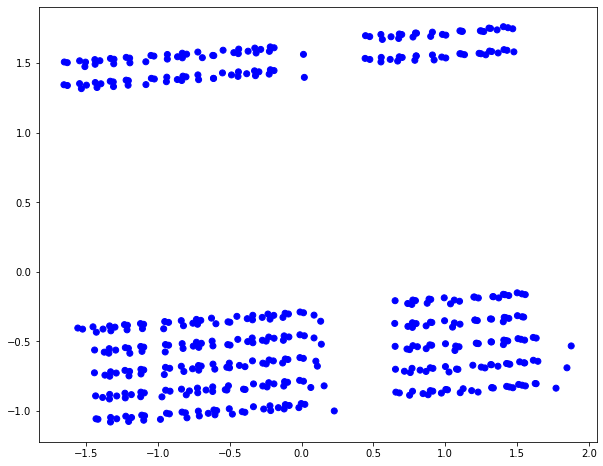

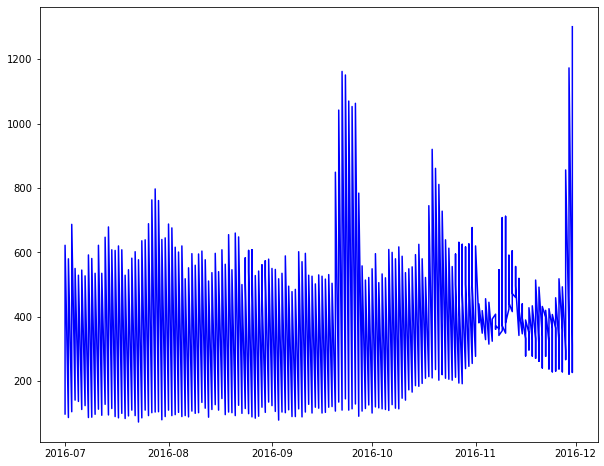

In [25]:
distance = getDistanceByPoint(data, kmeans[3])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()

# Считаем точку аномалией, если расстояние до центра кластера больше порога
df_tea3['anomaly_k_means1'] = (distance >= 3.0).astype(int)

fig, ax = plt.subplots(figsize=(10, 8))
colors = {0: 'blue', 1: 'red'}
ax.scatter(df_tea3['principal_feature1'], df_tea3['principal_feature2'],
           c=df_tea3["anomaly_k_means1"].apply(lambda x: colors[x]))
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))

a = df_tea3.loc[df_tea3['anomaly_k_means1'] ==
                1, ['date', 'receipts_count']]  # anomaly

ax.plot(df_tea3['date'], df_tea3['receipts_count'], color='blue')
ax.scatter(a['date'], a['receipts_count'], color='red')
plt.show()

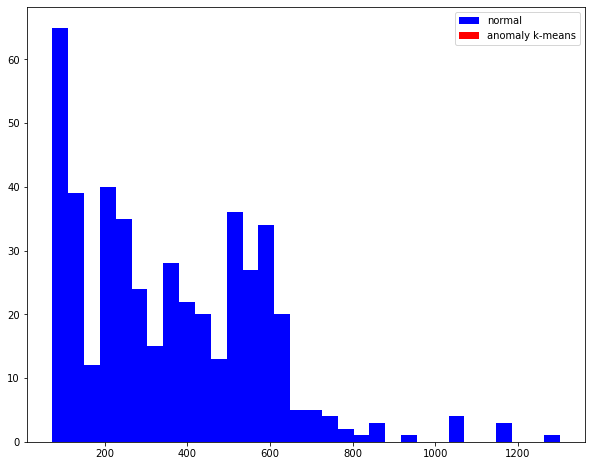

In [26]:
# Посмотрим на распределение аномальных и действительных значений
a = df_tea3.loc[df_tea3['anomaly_k_means1'] == 0, 'receipts_count']
b = df_tea3.loc[df_tea3['anomaly_k_means1'] == 1, 'receipts_count']
fig, axs = plt.subplots(figsize=(10,8))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly k-means'])
plt.legend()
plt.show()

In [27]:
# creation of 4 differents data set based on categories defined before
df_class0 = df_tea3.loc[df_tea3['brand_id'] == 5152, 'receipts_count'] # чай "May"
df_class1 = df_tea3.loc[df_tea3['brand_id'] == 178, 'receipts_count'] # чай "Ahmad"
df_class2 = df_tea3.loc[df_tea3['brand_id'] == 29, 'receipts_count'] # чай "Lipton"

<AxesSubplot:>

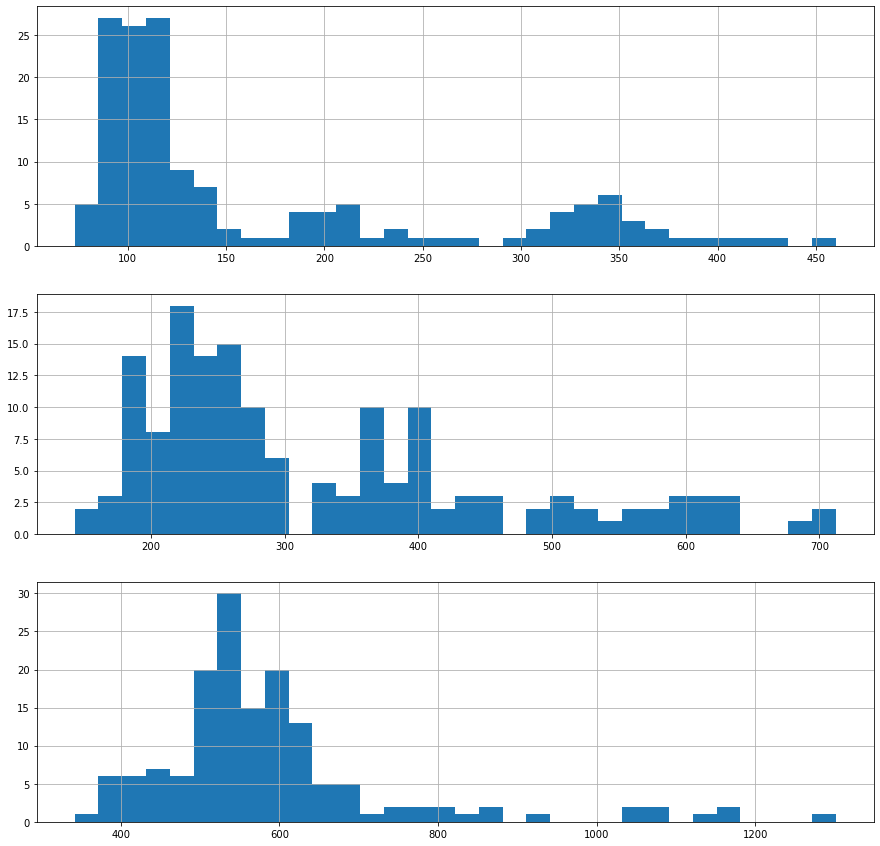

In [28]:
fig, axs = plt.subplots(3, figsize=(15,15))
df_class0.hist(ax=axs[0],bins=32)
df_class1.hist(ax=axs[1],bins=32)
df_class2.hist(ax=axs[2],bins=32)

In [29]:
# Попробуем статистически оценить количество аномалий

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class2.values.reshape(-1,1)
envelope.fit(X_train)
df_class2 = pd.DataFrame(df_class2)
df_class2['deviation'] = envelope.decision_function(X_train)
df_class2['anomaly'] = envelope.predict(X_train)

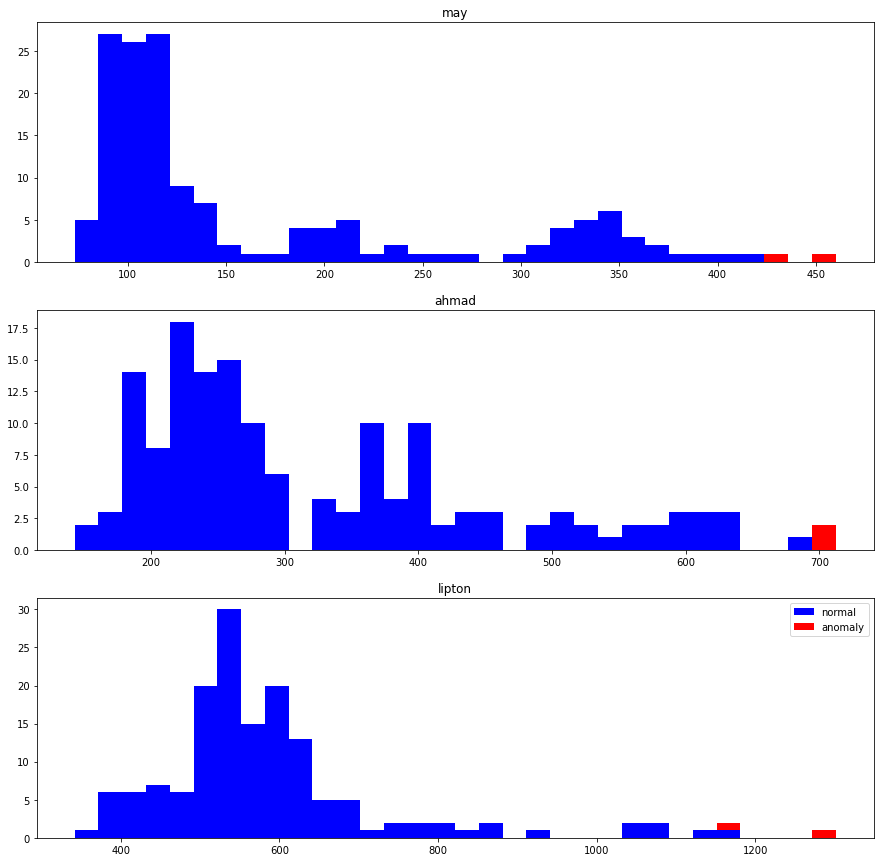

In [30]:
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'receipts_count']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'receipts_count']

a1 = df_class1.loc[df_class1['anomaly'] == 1, 'receipts_count']
b1 = df_class1.loc[df_class1['anomaly'] == -1, 'receipts_count']

a2 = df_class2.loc[df_class2['anomaly'] == 1, 'receipts_count']
b2 = df_class2.loc[df_class2['anomaly'] == -1, 'receipts_count']


fig, axs = plt.subplots(3,figsize=(15,15))
axs[0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1].hist([a1,b1], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[2].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0].set_title("may")
axs[1].set_title("ahmad")
axs[2].set_title("lipton")
plt.legend()
plt.show()

In [31]:
# add the data to the main 
df_class = pd.concat([df_class0, df_class1, df_class2])
df_tea3['anomaly_kmeans2'] = df_class['anomaly']
df_tea3['anomaly_kmeans2'] = np.array(df_tea3['anomaly_kmeans2'] == -1).astype(int) 

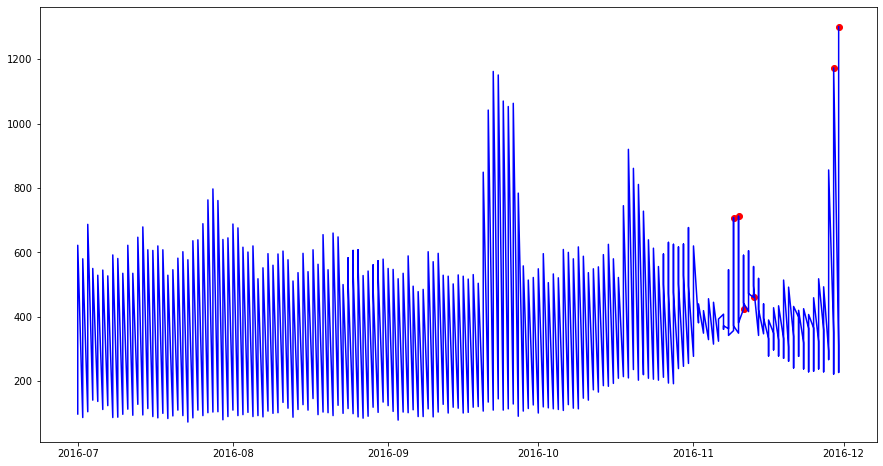

In [32]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots(figsize=(15,8))

a = df_tea3.loc[df_tea3['anomaly_kmeans2'] == 1, ('date', 'receipts_count')] #anomaly

ax.plot(df_tea3['date'], df_tea3['receipts_count'], color='blue')
ax.scatter(a['date'],a['receipts_count'], color='red')
plt.show()

In [33]:
anomaly_date(a['date'])

Аномалии между играми 2016-06-19 и 2016-09-25
[]
Аномалии между играми 2016-09-25 и 2016-10-02
[]
Аномалии между играми 2016-10-02 и 2016-10-09
[]
Аномалии между играми 2016-10-09 и 2016-10-16
[]
Аномалии между играми 2016-10-16 и 2016-10-23
[]
Аномалии между играми 2016-10-23 и 2016-11-20
['2016-11-09', '2016-11-10', '2016-11-11', '2016-11-13']
Аномалии между играми 2016-11-20 и 2016-11-27
[]
Аномалии между играми 2016-11-27 и 2016-12-11
['2016-11-29', '2016-11-30']
Аномалии между играми 2016-12-11 и 2016-12-18
[]
Аномалии между играми 2016-12-18 и 2016-12-25
[]


#### Вывод: 
С помощью k-means найдены аномалии, однако они снова не подтверждают увеличение продаж после игр. Только 2 аномалии выявлены через два дня после одной игры в ноябре, в то время как остальные аномалии приходятся также на ноябрь, но до игр, которые прошли 20 и 27 ноября 2016 года.

### 3.2 DBSCAN

In [34]:
dbscan = DBSCAN(eps=2)

In [35]:
df_tea3['prediction_dbscan_1'] = dbscan.fit_predict(df_tea3['receipts_count'].values.reshape(-1, 1))
df_tea3.head()

,brand_id,date,receipts_count,DayOfTheWeek,WeekDay,quarter,month,dayofyear,dayofmonth,weekofyear,weekend,weekday_name,season,cluster,principal_feature1,principal_feature2,anomaly_k_means1,anomaly_kmeans2,prediction_dbscan_1
0,5152,2016-07-01,98,4,1,3,7,183,1,26,0,Friday,SUMMER,0,-1.558027,-0.403450,0,0,0
1,178,2016-07-01,234,4,1,3,7,183,1,26,0,Friday,SUMMER,0,-1.524532,-0.411194,0,0,1
2,29,2016-07-01,622,4,1,3,7,183,1,26,0,Friday,SUMMER,0,-1.428975,-0.433285,0,0,2
3,5152,2016-07-02,87,5,0,3,7,184,2,26,1,Saturday,SUMMER,3,-1.654528,1.345196,0,0,0
4,178,2016-07-02,185,5,0,3,7,184,2,26,1,Saturday,SUMMER,3,-1.630392,1.339616,0,0,3


In [36]:
# Обнаруженные аномалии
dbscan_df = df_tea3['date'][df_tea3.prediction_dbscan_1 < 0]
dbscan_df

8     2016-07-03
9     2016-07-04
12    2016-07-05
13    2016-07-05
25    2016-07-09
         ...    
450   2016-11-28
452   2016-11-28
455   2016-11-29
456   2016-11-30
458   2016-11-30
Name: date, Length: 153, dtype: datetime64[ns]

In [37]:
anomaly_date(dbscan_df)

Аномалии между играми 2016-06-19 и 2016-09-25
['2016-07-03', '2016-07-04', '2016-07-05', '2016-07-09', '2016-07-11', '2016-07-12', '2016-07-13', '2016-07-14', '2016-07-16', '2016-07-21', '2016-07-22', '2016-07-23', '2016-07-24', '2016-07-25', '2016-07-26', '2016-07-27', '2016-07-28', '2016-07-29', '2016-07-30', '2016-07-31', '2016-08-01', '2016-08-02', '2016-08-03', '2016-08-05', '2016-08-06', '2016-08-07', '2016-08-09', '2016-08-11', '2016-08-13', '2016-08-16', '2016-08-17', '2016-08-18', '2016-08-19', '2016-08-21', '2016-08-22', '2016-08-23', '2016-08-24', '2016-08-25', '2016-08-28', '2016-08-29', '2016-08-30', '2016-08-31', '2016-09-01', '2016-09-03', '2016-09-05', '2016-09-06', '2016-09-07', '2016-09-08', '2016-09-09', '2016-09-10', '2016-09-13', '2016-09-18', '2016-09-20', '2016-09-21', '2016-09-22', '2016-09-23', '2016-09-24', '2016-09-25']
Аномалии между играми 2016-09-25 и 2016-10-02
['2016-09-25', '2016-09-26', '2016-09-27', '2016-09-30']
Аномалии между играми 2016-10-02 и 201

#### Вывод: 
DBCSCAN найдены 153 аномалии. Однако, нельзя однозначно утверждать, что продажи росли из-за рекламы. Между играми в июне и сентябре был перерыв 3 месяца и в этот период наблюдается большое число аномалий, в то время как после декабрьских игр аномалий не наблюдается совсем.

### 3.3 Агломеративная кластеризация

In [38]:
agglom = AgglomerativeClustering(n_clusters=None, distance_threshold=2)

In [39]:
df_tea3['prediction_agglom_1'] = agglom.fit_predict(df_tea3['receipts_count'].values.reshape(-1, 1))
df_tea3.head()

,brand_id,date,receipts_count,DayOfTheWeek,WeekDay,quarter,month,dayofyear,dayofmonth,weekofyear,weekend,weekday_name,season,cluster,principal_feature1,principal_feature2,anomaly_k_means1,anomaly_kmeans2,prediction_dbscan_1,prediction_agglom_1
0,5152,2016-07-01,98,4,1,3,7,183,1,26,0,Friday,SUMMER,0,-1.558027,-0.403450,0,0,0,121
1,178,2016-07-01,234,4,1,3,7,183,1,26,0,Friday,SUMMER,0,-1.524532,-0.411194,0,0,1,176
2,29,2016-07-01,622,4,1,3,7,183,1,26,0,Friday,SUMMER,0,-1.428975,-0.433285,0,0,2,162
3,5152,2016-07-02,87,5,0,3,7,184,2,26,1,Saturday,SUMMER,3,-1.654528,1.345196,0,0,0,21
4,178,2016-07-02,185,5,0,3,7,184,2,26,1,Saturday,SUMMER,3,-1.630392,1.339616,0,0,3,174


In [40]:
valcount = df_tea3['prediction_agglom_1'].value_counts()
valcount = set(valcount[valcount == 1].index)
aggl_df = df_tea3['date'][df_tea3.prediction_agglom_1.isin(valcount)]
aggl_df

12    2016-07-05
13    2016-07-05
25    2016-07-09
41    2016-07-14
46    2016-07-16
         ...    
435   2016-11-23
452   2016-11-28
455   2016-11-29
456   2016-11-30
458   2016-11-30
Name: date, Length: 73, dtype: datetime64[ns]

In [41]:
anomaly_date(aggl_df)

Аномалии между играми 2016-06-19 и 2016-09-25
['2016-07-05', '2016-07-09', '2016-07-14', '2016-07-16', '2016-07-23', '2016-07-24', '2016-07-27', '2016-07-28', '2016-07-29', '2016-07-30', '2016-07-31', '2016-08-07', '2016-08-13', '2016-08-16', '2016-08-18', '2016-08-19', '2016-08-21', '2016-08-30', '2016-09-03', '2016-09-07', '2016-09-08', '2016-09-10', '2016-09-13', '2016-09-19', '2016-09-20', '2016-09-21', '2016-09-22', '2016-09-23', '2016-09-24', '2016-09-25']
Аномалии между играми 2016-09-25 и 2016-10-02
['2016-09-25', '2016-09-26', '2016-09-27', '2016-09-28', '2016-09-30']
Аномалии между играми 2016-10-02 и 2016-10-09
['2016-10-04', '2016-10-06', '2016-10-07', '2016-10-09']
Аномалии между играми 2016-10-09 и 2016-10-16
['2016-10-09', '2016-10-12', '2016-10-13']
Аномалии между играми 2016-10-16 и 2016-10-23
['2016-10-18', '2016-10-19', '2016-10-20', '2016-10-21', '2016-10-22']
Аномалии между играми 2016-10-23 и 2016-11-20
['2016-10-24', '2016-10-27', '2016-10-28', '2016-10-31', '201

#### Вывод: 
Агломеративная кластеризация выявила 73 аномалии. Подтверждается вывод сделанный по результатам DBSCAN.

# 4.  Mодель, предсказывающая значение временного ряда продаж. 


### 4.1 Посмотрим модель с isolation forest

In [42]:
# train isolation forest 
model =  IsolationForest(contamination=0.5, random_state=42).fit(data)
# add the data to the main  
df_tea3['anomaly_is_forest'] = pd.Series(model.predict(data))
df_tea3['anomaly_is_forest'] = df_tea3['anomaly_is_forest'].map( {1: 0, -1: 1} )
print(df_tea3['anomaly_is_forest'].value_counts())

0    230
1    229
Name: anomaly_is_forest, dtype: int64


In [43]:
df_tea3['value_diff'] = df_tea3['receipts_count'].diff(1)
df_tea3.dropna(inplace=True)

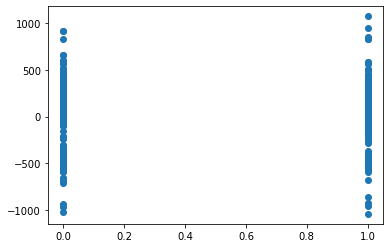

In [44]:
plt.scatter(df_tea3['anomaly_is_forest'], df_tea3['value_diff'])

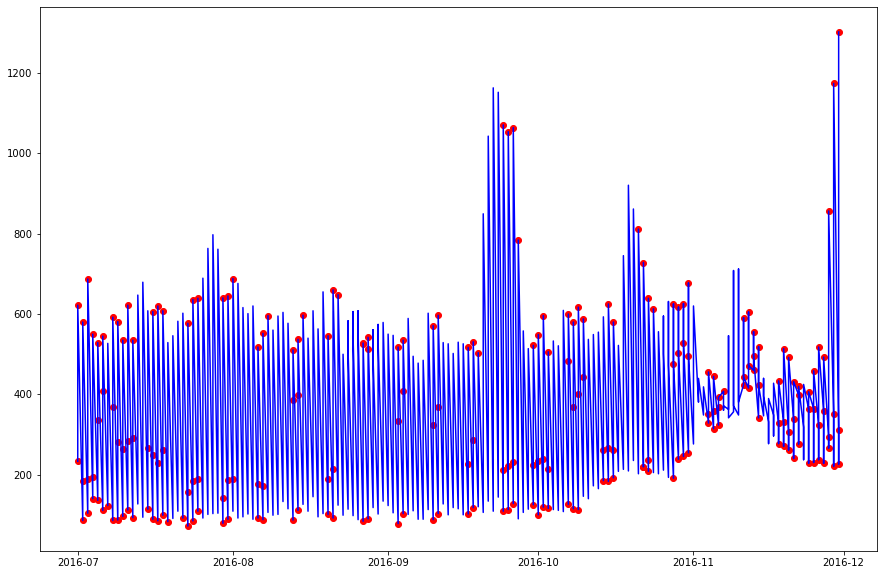

In [45]:
# visualisation of anomaly throughout time (viz 1)
plt.figure(figsize=(15, 10))

a = df_tea3.loc[df_tea3['anomaly_is_forest'] == 1, ['date', 'receipts_count']] #anomaly

plt.plot(df_tea3['date'], df_tea3['receipts_count'], color='blue')
plt.scatter(a['date'],a['receipts_count'], color='red')
plt.show()

In [46]:
# Аномалии в сентябре после игры
a['date'][(a['date']>'2016-09-24') & (a['date']<'2016-10-02')].count()

13

In [47]:
# Аномалии в октябре после игр
a['date'][(a['date']>'2016-10-02') & (a['date']<'2016-10-24')].count()

29

In [48]:
# Аномалии в ноябре после игр
a['date'][(a['date']>'2016-11-20') & (a['date']<'2016-12-12')].count()

27

In [49]:
# Аномалии в декабре после игр
a['date'][(a['date']>'2016-12-11') & (a['date']<'2016-12-31')].count()

0

In [50]:
# аномалии после игр
anomaly_date(a['date'])

Аномалии между играми 2016-06-19 и 2016-09-25
['2016-07-01', '2016-07-02', '2016-07-03', '2016-07-04', '2016-07-05', '2016-07-06', '2016-07-07', '2016-07-08', '2016-07-09', '2016-07-10', '2016-07-11', '2016-07-12', '2016-07-15', '2016-07-16', '2016-07-17', '2016-07-18', '2016-07-19', '2016-07-22', '2016-07-23', '2016-07-24', '2016-07-25', '2016-07-30', '2016-07-31', '2016-08-01', '2016-08-06', '2016-08-07', '2016-08-08', '2016-08-13', '2016-08-14', '2016-08-15', '2016-08-20', '2016-08-21', '2016-08-22', '2016-08-27', '2016-08-28', '2016-09-03', '2016-09-04', '2016-09-10', '2016-09-11', '2016-09-17', '2016-09-18', '2016-09-19', '2016-09-24', '2016-09-25']
Аномалии между играми 2016-09-25 и 2016-10-02
['2016-09-25', '2016-09-26', '2016-09-27', '2016-09-30', '2016-10-01', '2016-10-02']
Аномалии между играми 2016-10-02 и 2016-10-09
['2016-10-02', '2016-10-03', '2016-10-07', '2016-10-08', '2016-10-09']
Аномалии между играми 2016-10-09 и 2016-10-16
['2016-10-09', '2016-10-10', '2016-10-14', 

#### Выводы: 
Изолирующий лес выявил больше аномалий которые могут свидетельствовать о том, что реклама трех сортов чая в играх Что?Где?Когда? влияет на рост продаж этих сортов чая. Однако, отсутствие аномалий в декбрьских играх может говорить об обратном. ПРи этом положительный misprediction не наблюдается.

In [51]:
# Применим OneClassSvm

from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data)
 
model = OneClassSVM()
data = pd.DataFrame(np_scaled)
model.fit(data)  
df_tea3['anomaly_smv'] = pd.Series(model.predict(data))
df_tea3['anomaly_smv'] = df_tea3['anomaly_smv'].map( {1: 0, -1: 1} )
print(df_tea3['anomaly_smv'].value_counts())

0    231
1    227
Name: anomaly_smv, dtype: int64


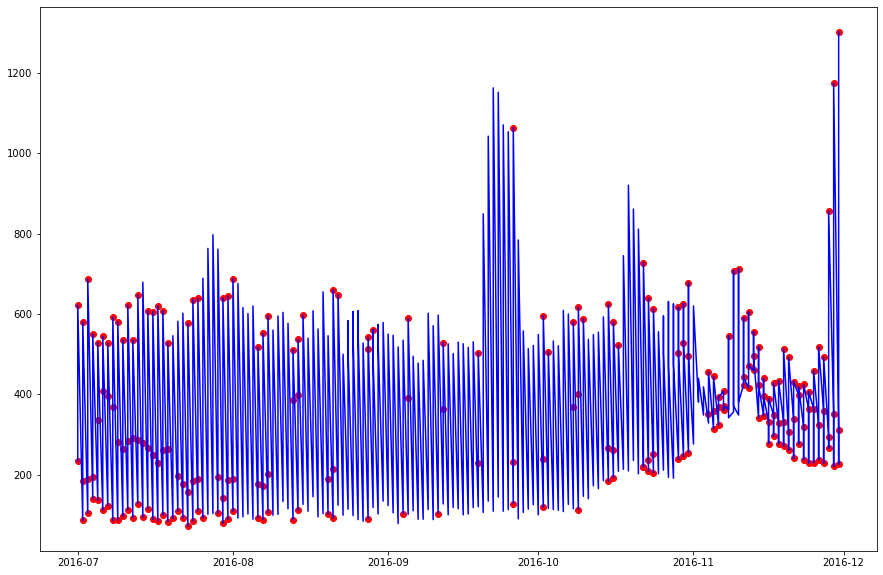

In [52]:
#visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots(figsize=(15, 10))

a = df_tea3.loc[df_tea3['anomaly_smv'] == 1, ['date', 'receipts_count']] #anomaly

ax.plot(df_tea3['date'], df_tea3['receipts_count'], color='blue')
ax.scatter(a['date'],a['receipts_count'], color='red')
plt.show()

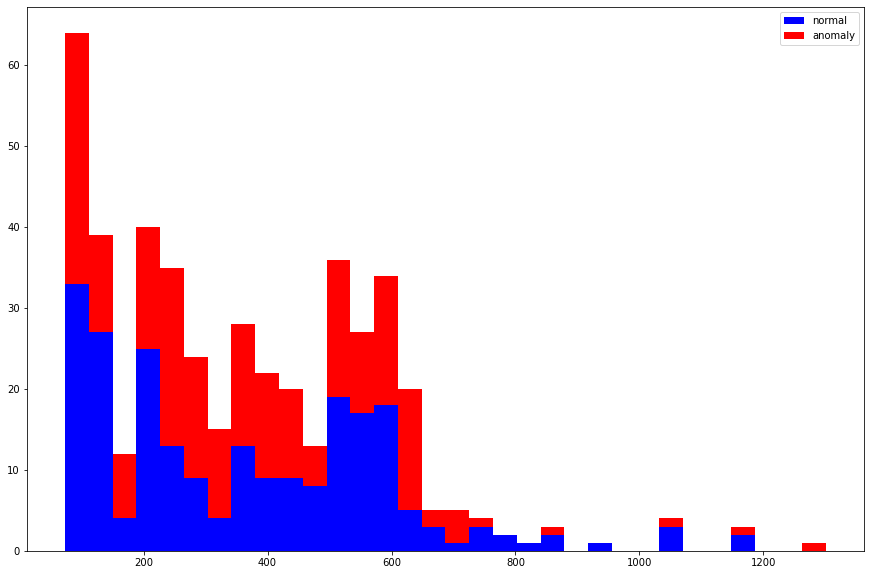

In [53]:
a1 = df_tea3.loc[df_tea3['anomaly_smv'] == 0, 'receipts_count']
b = df_tea3.loc[df_tea3['anomaly_smv'] == 1, 'receipts_count']

fig, axs = plt.subplots(figsize=(15, 10))
axs.hist([a1,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

In [54]:
# аномалии после игр
anomaly_date(a['date'])

Аномалии между играми 2016-06-19 и 2016-09-25
['2016-07-01', '2016-07-02', '2016-07-03', '2016-07-04', '2016-07-05', '2016-07-06', '2016-07-07', '2016-07-08', '2016-07-09', '2016-07-10', '2016-07-11', '2016-07-12', '2016-07-13', '2016-07-14', '2016-07-15', '2016-07-16', '2016-07-17', '2016-07-18', '2016-07-19', '2016-07-20', '2016-07-21', '2016-07-22', '2016-07-23', '2016-07-24', '2016-07-25', '2016-07-26', '2016-07-29', '2016-07-30', '2016-07-31', '2016-08-01', '2016-08-06', '2016-08-07', '2016-08-08', '2016-08-13', '2016-08-14', '2016-08-15', '2016-08-20', '2016-08-21', '2016-08-22', '2016-08-28', '2016-08-29', '2016-09-04', '2016-09-05', '2016-09-11', '2016-09-12', '2016-09-19']
Аномалии между играми 2016-09-25 и 2016-10-02
['2016-09-26', '2016-10-02']
Аномалии между играми 2016-10-02 и 2016-10-09
['2016-10-02', '2016-10-03', '2016-10-08', '2016-10-09']
Аномалии между играми 2016-10-09 и 2016-10-16
['2016-10-09', '2016-10-10', '2016-10-15', '2016-10-16']
Аномалии между играми 2016-1

In [55]:
# Аномалии летом после игр
a['date'][(a['date']>'2016-06-19') & (a['date']<'2016-08-31')].count()

107

In [56]:
# Аномалии осенью после игр
a['date'][(a['date']>'2016-08-31') & (a['date']<'2016-12-01')].count()

120

In [57]:
# Аномалии в декабре после игр
a['date'][(a['date']>'2016-12-10') & (a['date']<'2016-12-31')].count()

0

#### Выводы: 
SVM выявил также много аномалий и вывод аналогичен выводу с изолирующим лесом.